In [1]:
!pip install osmnx keplergl geopandas shapely matplotlib pandas seaborn numpy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import osmnx as ox
import networkx as nx
from keplergl import KeplerGl
import plotly.express as px
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, LineString
import matplotlib.pyplot as plt
import numpy as np
from shapely import STRtree
from shapely.ops import unary_union
import seaborn as sns

# Data integration

#### Get boundary of Graz and districts

In [3]:
# define the place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

<Axes: >

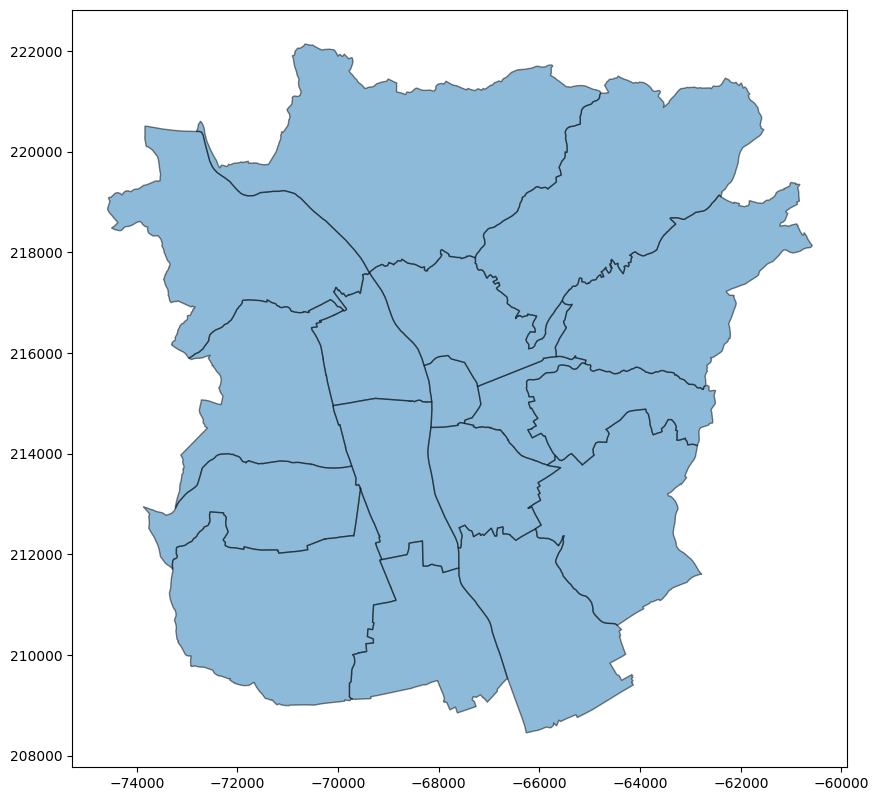

In [4]:
# Get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

# plot the districts
gdf_districts.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

#### Population data

<Axes: >

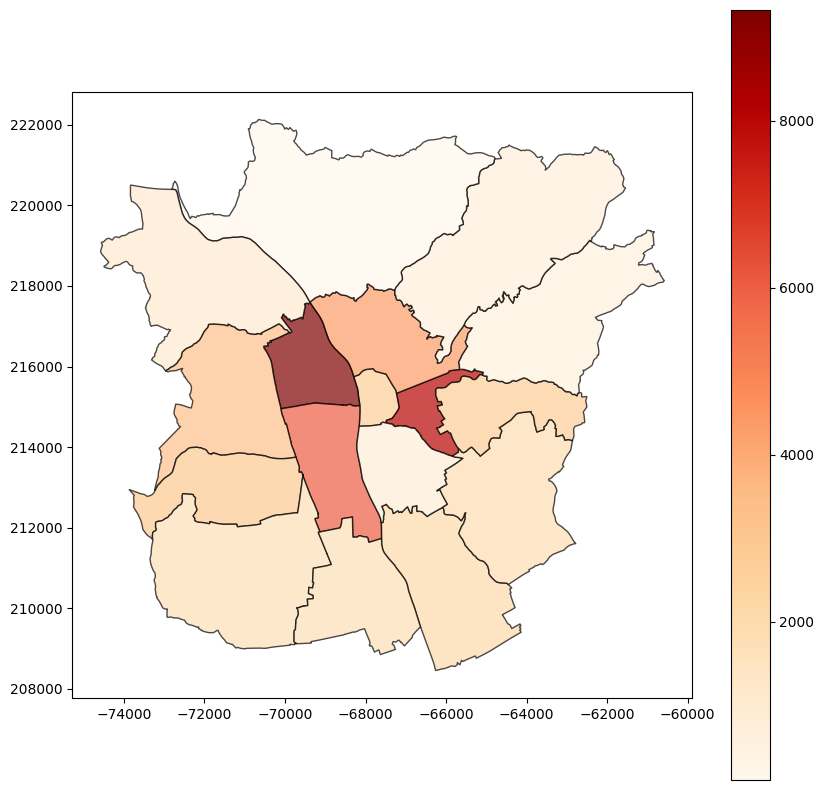

In [ ]:
# Import population data and merge with districts
df_population = pd.read_csv("graz_bev.csv", header=0, sep=';')
gdf_bev_districts = gdf_districts.merge(df_population, left_on='name', right_on='Bezirk')
gdf_bev_districts = gdf_bev_districts.drop(columns=['Bezirk'])

#### Residential areas

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 251 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


<Axes: >

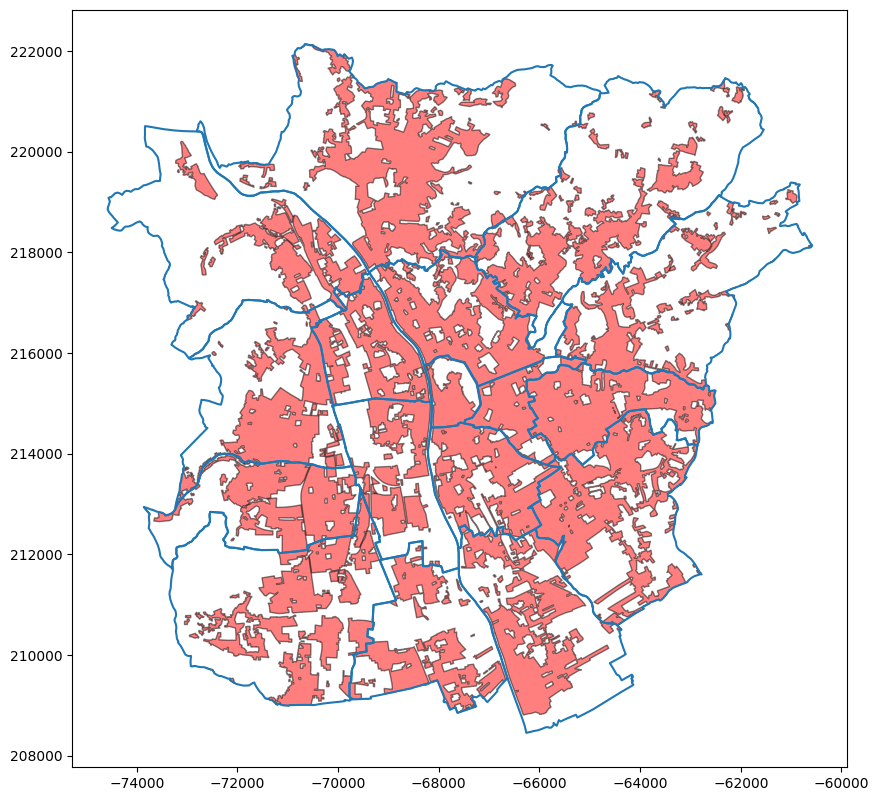

In [ ]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)
# dissolve all residential areas into one single geometry and cut to the boundary of Graz
gdf_residential = gdf_residential.dissolve()
gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

#### Network of Graz

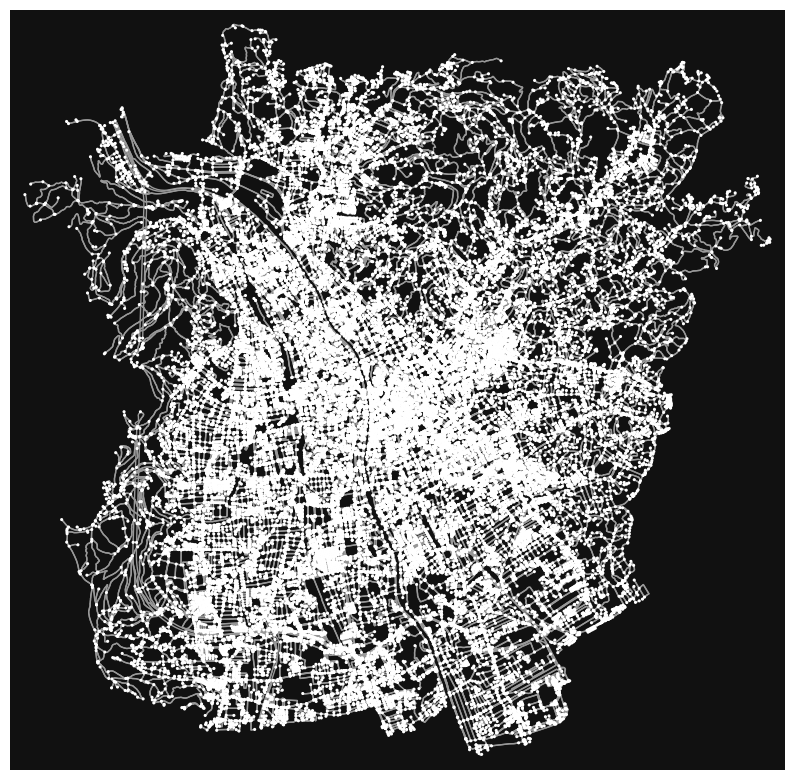

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [7]:
#if street network already exists, load it (to save time), otherwise download and save it
try:
    network_graz = ox.load_graphml("graz_street_network.graphml")
except:
    # get the street network for walking within the boundary of Graz
    network_graz = ox.graph_from_place(place_name, network_type="all")
    network_graz = ox.project_graph(network_graz, to_crs="epsg:31256")
    #save the graph
    ox.save_graphml(network_graz, filepath="graz_street_network.graphml")

# Plot the network using osmnx built-in function
ox.plot_graph(network_graz, node_size=5, figsize=(10,10))

In [8]:
# Download Autobahnen and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 50 meters around highways
highway_buffer = highways.buffer(50)

#highways.plot()

#### Green spaces from OSMNX

<Axes: >

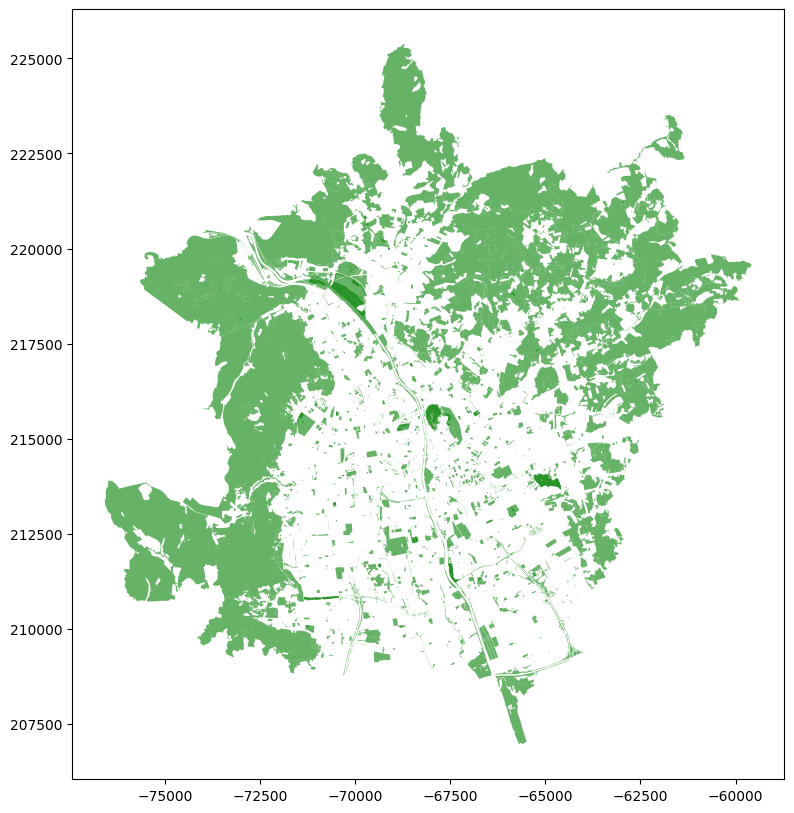

In [9]:
# Define tags for urban green spaces and parks
tags = {
    "leisure": ["park", "garden", "nature_reserve", "recreation_ground"],
    "landuse": ["forest", "grass", "meadow", "recreation_ground"]
}

tags = {
    "leisure": [
        "park",
        "garden",
        "nature_reserve",
        "recreation_ground",
        "pitch",          # often grassy sports fields
        "golf_course"
    ],
    "landuse": [
        "forest",
        "grass",
        "meadow",
        "recreation_ground",
        "allotments",
        "village_green",
        "cemetery"
    ],
    "natural": [
        "wood",
        "grassland",
        "scrub",
        "heath"
    ],
    "amenity": [
        "park",
        "playground"
        "graveyard"
    ]
}

# Download all green spaces in Graz & change the CRS
green_spaces = ox.features_from_place(place_name, tags=tags)
green_spaces = green_spaces[green_spaces.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
green_spaces = green_spaces.to_crs(epsg=31256)


# Quick visualization
green_spaces.plot(color='green', alpha=0.6, figsize=(10, 10))

# Data management

#### Exclude unsuitable green spaces

In [10]:
# Clean data
# exclude green spaces that intersect with highway buffer
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

#keep only relevant columns
green_spaces = green_spaces[['geometry', 'amenity', 'leisure', 'landuse', 'natural', 'sport', 'name','access']]

C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\677269605.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


In [11]:
# Remove invalid green areas after visual inspection
green_spaces = green_spaces[~green_spaces['name'].isin(['Merkur Arena'])]
green_spaces = green_spaces[green_spaces['sport'].isna() | green_spaces['sport'].isin(['soccer', 'equestrian', 'golf', 'soccer; rugby', 'baseball', 'bmx', 'rugby', 'cricket', 'archery', 'baseball;cricket'])]


#### Extract public green areas

In [12]:

# Extract public-accessible green spaces (parks, urban forests, cemeteries etc.)
public_green = green_spaces[
    (green_spaces["leisure"].isin(["park", "garden", "recreation_ground"])) |
    (green_spaces["landuse"].isin(["forest", "recreation_ground", "cemetery"])) |
    (green_spaces["natural"].isin(["wood"])) |
    (green_spaces["amenity"].isin(["park", "playground", "graveyard"]))
]
# Drop private gardens without name
public_green = public_green[~((public_green["leisure"] == "garden") & (public_green["name"].isna()))]

#exclude public green spaces that are marked as 'no' or 'private' access
public_green = public_green[public_green['access'].isna() | public_green['access'].isin(['yes', 'permissive'])]

In [13]:
# Create categories for public green spaces: parks and gardens, urban forests, cemetery
# Create a new column 'category' based on conditions
def categorize_green_space(row):
    if row['leisure'] in ['park', 'garden', 'recreation_ground'] or row['landuse'] == 'recreation_ground' or row['amenity'] in ['park', 'playground']:
        return 'park_garden'
    elif row['landuse'] == 'forest' or row['natural'] == 'wood':
        return 'urban_forest'
    elif row['landuse'] == 'cemetery' or row['amenity'] == 'graveyard':
        return 'cemetery'
    else:
        return 'other' 
public_green['category'] = public_green.apply(categorize_green_space, axis=1)

In [14]:
# Exclude green spaces under 10000 m2
public_green_over_1ha = public_green[public_green.geometry.area >= 10000]
public_green_over_1ha = gpd.overlay(public_green_over_1ha, gdf_graz, how='intersection')

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [15]:
# Visualization of public green areas, with and without green spaces <1ha
map_public = KeplerGl(height=600)

map_public.add_data(data=public_green_over_1ha, name='Green spaces over 1ha')
map_public.add_data(data=public_green, name='All public green spaces')

map_public

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'Green spaces over 1ha': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…

#### Dissolve green space polygons

In [16]:
# Dissolve green areas by category (parks and gardens, urban forests, cemetery)
public_green_categories = public_green.dissolve(by='category', as_index=False)

# Dissolve all green areas and cut to Graz boundary
public_green_all = public_green_categories.dissolve(as_index=False)
#select only public green spaces within

edges = ox.graph_to_gdfs(network_graz, nodes=False, edges=True)

# Clip green spaces to Graz boundary
public_green_graz = gpd.clip(public_green_all, gdf_graz)

#### Get access points of parks

In [17]:
map_test = KeplerGl(height=600)
map_test.add_data(data=public_green_all, name='Public Green Spaces Graz Boundary')
map_test

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Public Green Spaces Graz Boundary': {'index': [0], 'columns': ['index', 'geometry', 'category'…

C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\254967105.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  park_boundaries = public_green_over_1ha.unary_union.boundary  # Get the actual geometry


Found 2337 access points


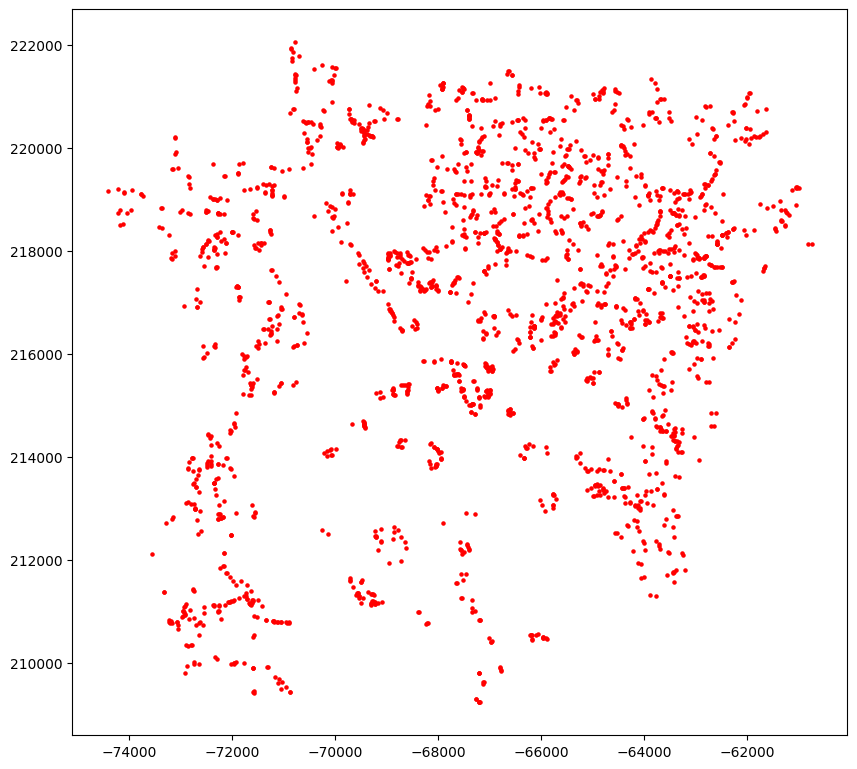

In [18]:
# Extract boundaries of parks as LineStrings
park_boundaries = public_green_over_1ha.unary_union.boundary  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

# Plot
access_points.plot(figsize=(10, 10), color='red', markersize=5)
print(f"Found {len(access_points)} access points")

In [19]:
# Visualization of access points, green spaces and street network
map_access = KeplerGl(height=600)

map_access.add_data(data=access_points, name='access points')
map_access.add_data(data=edges, name='street network')
map_access.add_data(data=public_green_over_1ha, name='public green spaces')

map_access

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23,…

# Method 1: Euclidean Distance

#### Buffer creation

In [ ]:
# Create distance buffers, and more metres around the park access points
DISTS:list[int] = [300, 500, 700]  # in meters

In [20]:
graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon

for d in DISTS:
    # Create buffers and clip to city boundary
    access_points[f'buffer_{d}m'] = access_points.geometry.buffer(d).intersection(graz_boundary)
#create buffer for distances over 300m and convert graz boundry to polygon
graz_polygon = gpd.GeoDataFrame(geometry=[graz_boundary], crs=access_points.crs)
access_points[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(access_points[f'buffer_{DISTS[-1]}m'].unary_union)

C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\243987708.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon
C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\243987708.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  access_points[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(access_points[f'buffer_{DISTS[-1]}m'].unary_union)


#### Dissolve buffers 

In [21]:
# Dissolve buffers
eucl_buffers = {}
#set previous buffer union to empty geometry
previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
#loop thorugh distances, dissolve and subtract previous buffers

for d in DISTS:
    eucl_buffers[d] = gpd.GeoDataFrame(geometry=access_points[f'buffer_{d}m']).dissolve()
    #subtract previous buffers to create rings
    eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(previous_union)
    #subtract public_green_all
    eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(public_green_over_1ha.unary_union)
    
    #update previous union
    previous_union = eucl_buffers[d].geometry.unary_union


# Dissolve buffer over 300m and subtract parks
eucl_buffers[f'over_{DISTS[-1]}m'] = gpd.GeoDataFrame(geometry=access_points[f'buffer_over_{DISTS[-1]}m'])
eucl_buffers[f'over_{DISTS[-1]}m']['geometry'] = eucl_buffers[f'over_{DISTS[-1]}m'].geometry.difference(public_green_over_1ha.unary_union)

C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\3657795060.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\3657795060.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\3657795060.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(public_green_over_1ha.unary_union)
C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\3657795060.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = eu

# Method 2: Network Analysis

For routing, the access points must exist as nodes in the network. For this, they need to be projected on edges and then added as nodes; the edges have to split up at the locations of the new access point nodes.

#### Project access points on edges of street network

In [22]:
print("Building spatial index...")

# Create array of edge geometries
edge_geoms = edges.geometry.values

# Build STRtree spatial index
tree = STRtree(edge_geoms)

print(f"Processing {len(access_points)} access points...")
access_point_edges = []

for idx, access_point in access_points.iterrows():
    point = access_point.geometry
    
    # Query nearest geometries using the spatial index
    # Use query with a small buffer to get candidates
    buffer_candidates = tree.query(point.buffer(100))  # 100m buffer to get candidates
    
    # If no candidates found with 100m, expand search
    if len(buffer_candidates) == 0:
        buffer_candidates = tree.query(point.buffer(500))
    
    # Find the truly closest edge among candidates
    min_distance = float('inf')
    best_edge_idx = None
    best_projection = None
    
    for candidate_idx in buffer_candidates:
        edge_geom = edge_geoms[candidate_idx]
        distance = point.distance(edge_geom)
        
        if distance < min_distance:
            min_distance = distance
            best_edge_idx = candidate_idx
            best_projection = edge_geom.interpolate(edge_geom.project(point))
    
    # If still no match found, do brute force search (shouldn't happen often)
    if best_edge_idx is None:
        distances = [point.distance(geom) for geom in edge_geoms]
        best_edge_idx = np.argmin(distances)
        min_distance = distances[best_edge_idx]
        best_projection = edge_geoms[best_edge_idx].interpolate(
            edge_geoms[best_edge_idx].project(point)
        )
    
    # Extract u and v from the MultiIndex
    edge_index = edges.index[best_edge_idx]
    u_node = edge_index[0]
    v_node = edge_index[1]
    
    # Get edge properties
    edge_geom = edge_geoms[best_edge_idx]
    edge_length = edge_geom.length
    dist_from_u = edge_geom.project(best_projection)
    
    access_point_edges.append({
        'access_point_id': idx,
        'edge_idx': best_edge_idx,
        'projected_point': best_projection,
        'distance_to_edge': min_distance,
        'u': u_node,
        'v': v_node,
        'total_edge_length': edge_length,
        'distance_from_u': dist_from_u,
    })
    
    # Progress indicator
    if (len(access_point_edges)) % 100 == 0:
        print(f"Processed {len(access_point_edges)}/{len(access_points)} access points")

# Create the DataFrame
access_edges_df = pd.DataFrame(access_point_edges)

print(f"\nProcessed {len(access_edges_df)} access points")
print(f"Max distance to nearest edge: {access_edges_df['distance_to_edge'].max():.2f}m")
print(f"Mean distance to nearest edge: {access_edges_df['distance_to_edge'].mean():.2f}m")

Building spatial index...
Processing 2337 access points...
Processed 100/2337 access points
Processed 200/2337 access points
Processed 300/2337 access points
Processed 400/2337 access points
Processed 500/2337 access points
Processed 600/2337 access points
Processed 700/2337 access points
Processed 800/2337 access points
Processed 900/2337 access points
Processed 1000/2337 access points
Processed 1100/2337 access points
Processed 1200/2337 access points
Processed 1300/2337 access points
Processed 1400/2337 access points
Processed 1500/2337 access points
Processed 1600/2337 access points
Processed 1700/2337 access points
Processed 1800/2337 access points
Processed 1900/2337 access points
Processed 2000/2337 access points
Processed 2100/2337 access points
Processed 2200/2337 access points
Processed 2300/2337 access points

Processed 2337 access points
Max distance to nearest edge: 0.00m
Mean distance to nearest edge: 0.00m


#### Add notes to the graph

In [23]:
print(f"Original graph: {network_graz.number_of_nodes()} nodes, {network_graz.number_of_edges()} edges")

# Add virtual nodes to the graph
G_modified = network_graz.copy()

successful_splits = 0
skipped_edges = 0

for idx, row in access_edges_df.iterrows():
    virtual_node_id = f"access_{row['access_point_id']}"
    edge_u = row['u']
    edge_v = row['v']
    
    # Check if edge exists in graph
    if not G_modified.has_edge(edge_u, edge_v):
        print(f"Warning: Edge {edge_u}->{edge_v} not in graph, skipping")
        skipped_edges += 1
        continue
    
    # Get original edge data
    edge_data = G_modified[edge_u][edge_v]
    
    if isinstance(edge_data, dict):
        # MultiGraph - get the first edge (key 0)
        if 0 in edge_data:
            original_edge = edge_data[0].copy()
        else:
            # Take the first available key
            first_key = list(edge_data.keys())[0]
            original_edge = edge_data[first_key].copy()
    else:
        original_edge = edge_data.copy()
    
    # Get distances
    total_length = original_edge.get('length', row['total_edge_length'])
    dist_from_u = row['distance_from_u']
    dist_from_v = total_length - dist_from_u
    
    # Skip if virtual node would be too close to existing nodes (< 1m)
    if dist_from_u < 1.0 or dist_from_v < 1.0:
        skipped_edges += 1
        continue
    
    # Add virtual node
    G_modified.add_node(
        virtual_node_id,
        x=row['projected_point'].x,
        y=row['projected_point'].y
    )
    
    # Remove original edge (all keys if MultiGraph)
    G_modified.remove_edge(edge_u, edge_v)
    
    # Filter edge attributes to only include string keys
    edge_attrs = {
        k: v for k, v in original_edge.items() 
        if isinstance(k, str) and k != 'length'
    }
    
    # Add two new edges (split at access point)
    # Edge from u to virtual node
    G_modified.add_edge(
        edge_u, 
        virtual_node_id,
        length=dist_from_u,
        **edge_attrs
    )
    
    # Edge from virtual node to v
    G_modified.add_edge(
        virtual_node_id, 
        edge_v,
        length=dist_from_v,
        **edge_attrs
    )
    
    successful_splits += 1
    
    # Progress indicator
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(access_edges_df)} edges")

print(f"\nModified graph: {G_modified.number_of_nodes()} nodes, {G_modified.number_of_edges()} edges")
print(f"Successfully split {successful_splits} edges")
print(f"Skipped {skipped_edges} edges")
print(f"Added {successful_splits} virtual access point nodes")

Original graph: 58259 nodes, 153276 edges
Processed 200/2337 edges
Processed 300/2337 edges
Processed 500/2337 edges
Processed 600/2337 edges
Processed 900/2337 edges
Processed 1100/2337 edges
Processed 1200/2337 edges
Processed 1300/2337 edges
Processed 1400/2337 edges
Processed 1700/2337 edges
Processed 1800/2337 edges
Processed 1900/2337 edges
Processed 2000/2337 edges
Processed 2100/2337 edges
Processed 2200/2337 edges

Modified graph: 60090 nodes, 155107 edges
Successfully split 1831 edges
Skipped 506 edges
Added 1831 virtual access point nodes


In [24]:
# Visualize modified network and access points for checking

nodes_mod = ox.graph_to_gdfs(G_modified, nodes=True, edges=False)
edges_mod = ox.graph_to_gdfs(G_modified, nodes=False, edges=True)

map3 = KeplerGl(height=600)

map3.add_data(data=access_points, name='access points')
map3.add_data(data=edges_mod, name='edges')
map3.add_data(data=nodes_mod, name='nodes')

map3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23,…

In [25]:
# Calculate nearest node in the network for each access point (so points that were skipped because of restrictions in length of edge also get a node)
access_nodes = ox.distance.nearest_nodes(G_modified, access_points.geometry.x, access_points.geometry.y)

access_nodes = list(access_nodes)

#### Dijkstra's one-to-all routing between access points and all nodes within 300m walking distance

In [26]:
results = {}  
distance = max(DISTS)
lengths = nx.multi_source_dijkstra_path_length(
    G_modified,
    sources=access_nodes,
    cutoff=distance,
    weight='length',  # edge attribute
)
# lengths: {node: distance_to_nearest_access_node}
for node, dist in lengths.items():
    results[node] = dist

#### Join nodes with the distance information from the routing

In [27]:
dist_df = pd.DataFrame(list(results.items()), 
                      columns=['node_id', 'access_dist'])
dist_df.set_index('node_id', inplace=True)

nodes_distance = pd.merge(nodes_mod, dist_df, 
                     left_index=True, right_index=True, how='left')


In [28]:
# All nodes that are not reachable <300m are given the value inf
nodes_distance['access_dist'] = nodes_distance['access_dist'].fillna(9999)
#Set access distance of nodes that intersect public green spaces to 0
nodes_distance.loc[nodes_distance.geometry.intersects(public_green_over_1ha.unary_union), 'access_dist'] = 0


C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\476622468.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nodes_distance.loc[nodes_distance.geometry.intersects(public_green_over_1ha.unary_union), 'access_dist'] = 0


In [29]:
#convert acess distance to float
#nodes_distance['access_dist'] = nodes_distance['access_dist'].astype(float)
nodes_distance['access_dist'] 


osmid
20824331       1000.000000
35126490       1000.000000
20824406        157.816439
1450590079       92.969645
35127847        203.031428
                  ...     
access_4753       0.000000
access_4768       0.000000
access_4769       0.000000
access_4778       0.000000
access_4780       0.000000
Name: access_dist, Length: 60090, dtype: float64

In [30]:
# Visualize the nodes with the distances to the access points
map_distances = KeplerGl(height=600)

map_distances.add_data(data=access_points, name='access points')
map_distances.add_data(data=public_green_over_1ha, name='public green spaces')
map_distances.add_data(data=nodes_distance, name='nodes')


map_distances

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23,…

#### Calculate accessibility grid

In [31]:

from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union


# Use Graz boundary to define the grid extent
minx, miny, maxx, maxy = gdf_graz.total_bounds

# Create a grid covering all of Graz
resolution = 30  # grid cell resolution
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
xx, yy = np.meshgrid(x_coords, y_coords)

# Get node coordinates and distances
node_points = np.array([[p.x, p.y] for p in nodes_distance.geometry])
node_distances = nodes_distance['access_dist'].values

# Filter out inf values
valid_mask = node_distances < float('inf')
node_points_valid = node_points[valid_mask]
node_distances_valid = node_distances[valid_mask]

print("Interpolating distances across grid using nearest neighbor...")
# Use 'nearest' method instead of 'linear' to fill all areas
grid_distances = griddata(
    node_points_valid, 
    node_distances_valid, 
    (xx, yy), 
    method='nearest'  # Changed from 'linear' to 'nearest'
)

# Distance band definitions
distance_bands = [
    (0, DISTS[0], f'0-{DISTS[0]}m', '#2ecc71'),
    (DISTS[0], DISTS[1], f'{DISTS[0]}-{DISTS[1]}m', '#f39c12'),
    (DISTS[1], DISTS[2], f'{DISTS[1]}-{DISTS[2]}m', '#e74c3c'),
    (DISTS[2], float('inf'), f'>{DISTS[2]}m', '#95a5a6')
]

# Create grid cells as polygons - only those within Graz
print("Creating grid cells...")
grid_polygons = []

# Get the Graz polygon for intersection checks
graz_geom = gdf_graz.geometry.iloc[0]

for i in range(len(x_coords) - 1):
    for j in range(len(y_coords) - 1):
        # Create cell polygon
        cell = Polygon([
            (x_coords[i], y_coords[j]),
            (x_coords[i+1], y_coords[j]),
            (x_coords[i+1], y_coords[j+1]),
            (x_coords[i], y_coords[j+1])
        ])
        
        # Only keep cells that intersect Graz
        if not graz_geom.intersects(cell):
            continue
        
        # Clip cell to Graz boundary
        clipped_cell = cell.intersection(graz_geom)
        
        # Skip if intersection is empty or too small
        if clipped_cell.is_empty or clipped_cell.area < 1:
            continue
        
        # Get distance value for this cell
        dist_value = grid_distances[j, i]
        
        # Categorize
        for min_d, max_d, label, color in distance_bands:
            if min_d <= dist_value < max_d:
                grid_polygons.append({
                    'distance': dist_value,
                    'category': label,
                    'color': color,
                    'geometry': clipped_cell
                })
                break

grid_gdf = gpd.GeoDataFrame(grid_polygons, crs=nodes_mod.crs)

print(f"Created {len(grid_gdf)} grid cells within Graz")

# Dissolve into zones
print("Creating accessibility zones...")
zones = []

for min_d, max_d, label, color in distance_bands:
    cells_in_zone = grid_gdf[grid_gdf['category'] == label]
    
    if len(cells_in_zone) > 0:
        merged = unary_union(cells_in_zone.geometry.values)
        area_km2 = merged.area / 1000000
        
        zones.append({
            'category': label,
            'min_distance': min_d,
            'max_distance': max_d,
            'color': color,
            'geometry': merged,
            'area_km2': area_km2
        })

zones_gdf = gpd.GeoDataFrame(zones, crs=nodes_mod.crs)



Interpolating distances across grid using nearest neighbor...
Creating grid cells...
Created 143070 grid cells within Graz
Creating accessibility zones...


In [32]:
# Visualize accessibility map
map_zones = KeplerGl(height=800)

map_zones.add_data(data=zones_gdf, name='Accessibility Zones')
map_zones.add_data(data=public_green_graz, name='Green Spaces')
map_zones.add_data(data=gdf_graz, name='graz')

map_zones

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make

KeplerGl(data={'Accessibility Zones': {'index': [0, 1, 2, 3], 'columns': ['category', 'min_distance', 'max_dis…

### General greenness in Graz

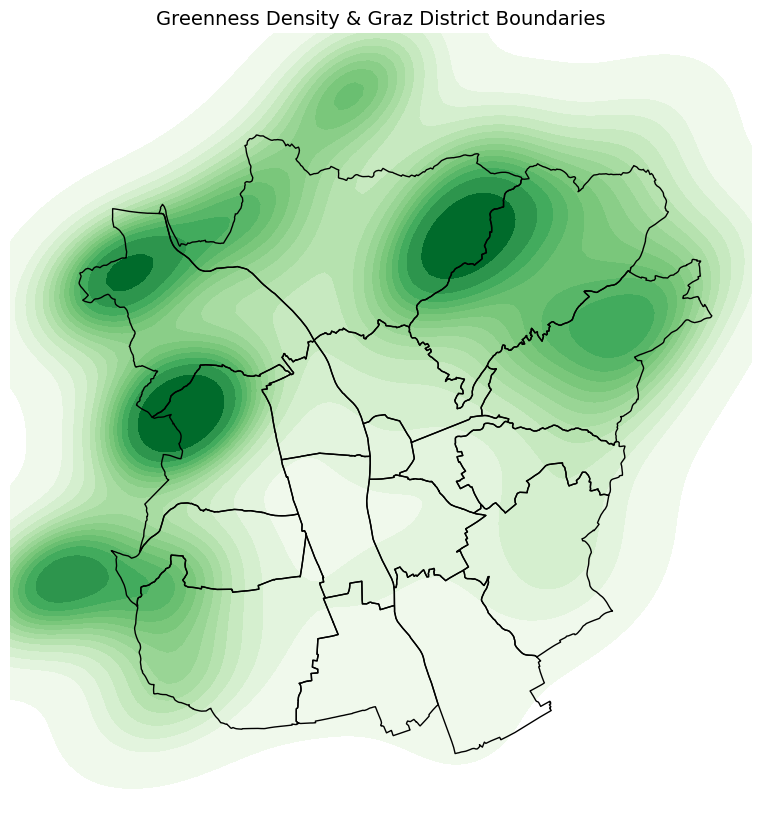

In [ ]:

#plot kde and districts of Graz
fig, ax = plt.subplots(figsize=(10, 10))

gdf_districts.plot(
    ax=ax,
    facecolor="none",     # no fill
    edgecolor="black",    # boundary lines
    linewidth=1,
    zorder=1
)



# Results

## Areal statistics

In [35]:
# Intersect buffers with residential areas
eucl_dist_res = {}
for key, value in eucl_buffers.items():
    eucl_dist_res[key] = gpd.overlay(value, gdf_residential, how='intersection')

# Calculate area and percentage of green residential areas by subtractig outer buffer from residential areas
green_areas_eucl = gpd.overlay(gdf_residential, eucl_buffers[f'over_{DISTS[-1]}m'], how='difference')
percent_green_eucl = (green_areas_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas within {DISTS[-1]}m of green space: {percent_green_eucl:.2f}%")


# Calculate deficient area (not within 300 m of green space) in total 
deficient_area_eucl = gpd.overlay(gdf_residential, eucl_buffers[f'over_{DISTS[-1]}m'], how='intersection')
percent_deficient_eucl = (deficient_area_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas not within {DISTS[-1]}m of green space: {percent_deficient_eucl:.2f}%")

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 525 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 389 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 771 dropped geometries of different geometry types than df1 has. Set `keep_geo

Percentage of residential areas within 300m of green space: 56.36%
Percentage of residential areas not within 300m of green space: 43.64%


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_typ

District: Innere Stadt, Percentage of residential areas not within 300m of green space: 31.29%
District: Liebenau, Percentage of residential areas not within 300m of green space: 79.34%
District: Sankt Leonhard, Percentage of residential areas not within 300m of green space: 28.04%
District: Geidorf, Percentage of residential areas not within 300m of green space: 14.77%
District: Lend, Percentage of residential areas not within 300m of green space: 57.29%
District: Gries, Percentage of residential areas not within 300m of green space: 53.81%
District: Jakomini, Percentage of residential areas not within 300m of green space: 67.12%
District: Sankt Peter, Percentage of residential areas not within 300m of green space: 28.55%
District: Waltendorf, Percentage of residential areas not within 300m of green space: 44.67%
District: Ries, Percentage of residential areas not within 300m of green space: 3.64%
District: Mariatrost, Percentage of residential areas not within 300m of green space: 12

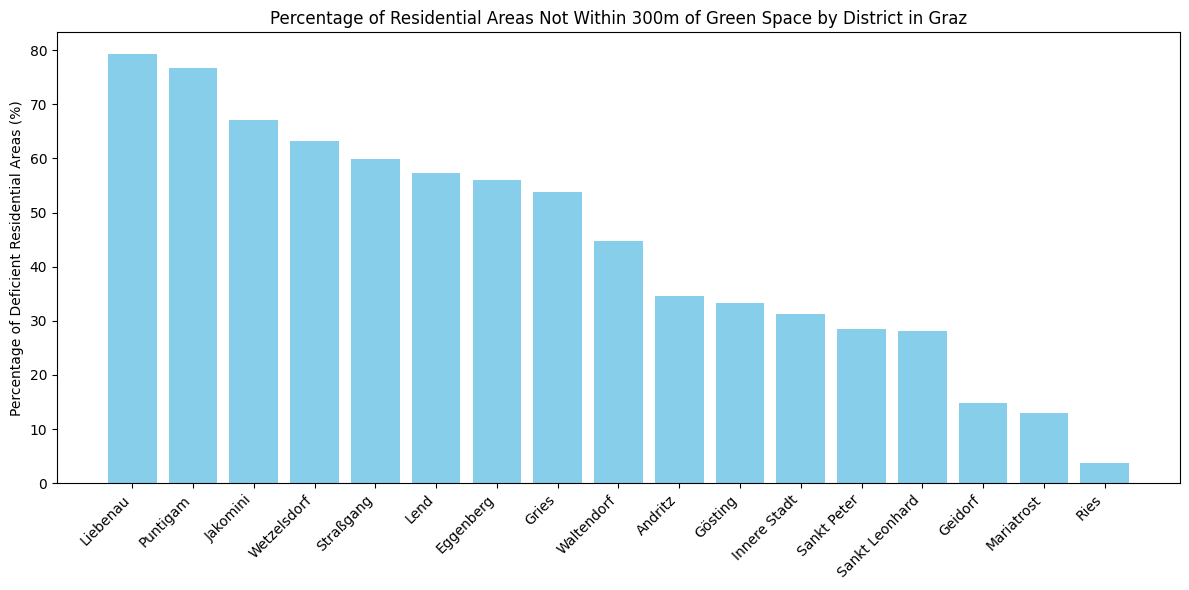

In [36]:
# Calculate deficient areas for each district
deficient_areas_districts = {}
for district in gdf_districts['name']:
    district_geom = gdf_districts[gdf_districts['name'] == district].geometry.union_all()
    residential_in_district = gpd.overlay(gdf_residential, gpd.GeoDataFrame(geometry=[district_geom], crs=gdf_residential.crs), how='intersection')
    deficient_area_district = gpd.overlay(residential_in_district, eucl_buffers[f'over_{DISTS[-1]}m'], how='intersection')
    percent_deficient_district = (deficient_area_district.geometry.area.sum() / residential_in_district.geometry.area.sum()) * 100
    deficient_areas_districts[district] = percent_deficient_district

# Print results and create bar chart
for district, percent_deficient_district in deficient_areas_districts.items():
    print(f"District: {district}, Percentage of residential areas not within {DISTS[-1]}m of green space: {percent_deficient_district:.2f}%")

# Create bar chart sorted by percentage
deficient_areas_districts_sorted = dict(sorted(deficient_areas_districts.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(deficient_areas_districts_sorted.keys(), deficient_areas_districts_sorted.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Deficient Residential Areas (%)')
plt.title(f'Percentage of Residential Areas Not Within {DISTS[-1]}m of Green Space by District in Graz')
plt.tight_layout()
plt.show()

In [37]:
# How much of residential areas are within each buffer?
buffer_res_eucl = {}
buffer_res_eucl_area = {}
for key, value in eucl_buffers.items():
    buffer_res_eucl[key] = gpd.overlay(value, gdf_residential, how='intersection')
    buffer_res_eucl_area[key] = buffer_res_eucl[key].geometry.area.sum()/gdf_residential.geometry.area.sum() * 100
    # Print percentual areas
    print(f"Percentage of residential areas within {key}m of green space: {buffer_res_eucl_area[key]:.2f}%")

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 525 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Percentage of residential areas within 100m of green space: 15.19%


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 389 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Percentage of residential areas within 200m of green space: 22.78%
Percentage of residential areas within 300m of green space: 33.22%
Percentage of residential areas within over_300mm of green space: 43.64%


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 771 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [38]:
# Population within each distance?
## intersect districts with buffers and sum population
population_within_buffers = {}
for key, value in eucl_buffers.items():
    intersected = gpd.overlay(gdf_bev_districts, value, how='intersection')
    intersected['area'] = intersected.geometry.area
    intersected['population_within_buffer'] = (intersected['area'] / gdf_bev_districts.set_index('name').loc[intersected['name'], 'geometry'].area.values) * gdf_bev_districts.set_index('name').loc[intersected['name'], 'EW'].values
    total_population = intersected['population_within_buffer'].sum()
    population_within_buffers[key] = total_population
    print(f"Population within {key}m of green space: {total_population:.0f}, ({(total_population / gdf_bev_districts['EW'].sum()) * 100:.2f}%)")

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 258 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Population within 100m of green space: 26486, (10.13%)


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 82 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Population within 200m of green space: 38178, (14.60%)
Population within 300m of green space: 62953, (24.08%)
Population within over_300mm of green space: 117301, (44.86%)


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 314 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


#### General "greenness": public and non-public

In [39]:
print("=" * 60)
print("GREEN SPACE ANALYSIS - GRAZ")
print("=" * 60)

# Clip green spaces to Graz boundary and dissolve to one polygon
green_spaces_graz = green_spaces.dissolve()
green_spaces_graz = gpd.clip(green_spaces, gdf_graz)

# 1. Calculate total green area in Graz
total_graz_area = gdf_graz.geometry.area.sum() / 1000000  # km²
total_green_area = green_spaces.geometry.area.sum() / 1000000  # km²
green_percentage_graz = (total_green_area / total_graz_area) * 100

print(f"\nGRAZ OVERALL:")
print(f"  Total area:        {total_graz_area:.2f} km²")
print(f"  Green space area:  {total_green_area:.2f} km²")
print(f"  Green percentage:  {green_percentage_graz:.1f}%")

# 2. Calculate green area per district
print(f"\n{'DISTRICT':<30} {'AREA (km²)':>12} {'GREEN (km²)':>12} {'GREEN %':>10}")
print("-" * 60)

district_stats = []

for idx, district in gdf_districts.iterrows():
    district_name = district.get('name', f'District {idx}')  # Adjust column name if needed
    district_geom = district.geometry
    district_area = district_geom.area / 1000000  # km²
    
    # Find green spaces within this district
    green_in_district = gpd.clip(green_spaces, gpd.GeoSeries([district_geom], crs=gdf_districts.crs))
    
    if len(green_in_district) > 0:
        green_area = green_in_district.geometry.area.sum() / 1000000  # km²
    else:
        green_area = 0
    
    green_percentage = (green_area / district_area * 100) if district_area > 0 else 0
    
    district_stats.append({
        'district': district_name,
        'district_area_km2': district_area,
        'green_area_km2': green_area,
        'green_percentage': green_percentage
    })
    
    print(f"{district_name:<30} {district_area:>12.2f} {green_area:>12.2f} {green_percentage:>9.1f}%")

# Create DataFrame with results
df_stats = pd.DataFrame(district_stats)

# Sort by green percentage
df_stats_sorted = df_stats.sort_values('green_percentage', ascending=False)

print("\n" + "=" * 60)
print("DISTRICTS RANKED BY GREEN PERCENTAGE:")
print("=" * 60)

for idx, row in df_stats_sorted.iterrows():
    print(f"{row['district']:<30} {row['green_percentage']:>6.1f}%")

GREEN SPACE ANALYSIS - GRAZ

GRAZ OVERALL:
  Total area:        127.58 km²
  Green space area:  75.50 km²
  Green percentage:  59.2%

DISTRICT                         AREA (km²)  GREEN (km²)    GREEN %
------------------------------------------------------------
Innere Stadt                           1.16         0.64      54.9%
Liebenau                               7.98         0.76       9.6%
Sankt Leonhard                         1.83         0.28      15.3%
Geidorf                                5.50         1.44      26.1%
Lend                                   3.71         0.43      11.6%
Gries                                  5.06         0.74      14.6%
Jakomini                               4.06         0.56      13.8%
Sankt Peter                            8.86         2.53      28.6%
Waltendorf                             4.48         0.85      19.0%
Ries                                  10.03         6.57      65.5%
Mariatrost                            14.11         8.83 

#### Green space accessibility (walking distances)

In [40]:
print("\n=== GREEN SPACE ACCESSIBILITY IN GRAZ ===")
total_area = zones_gdf['area_km2'].sum()
graz_total = gdf_graz.geometry.area.sum() / 1000000

print(f"Graz total area: {graz_total:.2f} km²")
print(f"Analyzed area: {total_area:.2f} km² ({total_area/graz_total*100:.1f}% of Graz)")
print()

for idx, row in zones_gdf.iterrows():
    percentage = (row['area_km2'] / total_area) * 100
    print(f"{row['category']:<15} {row['area_km2']:>8.2f} km² ({percentage:>5.1f}%)")


=== GREEN SPACE ACCESSIBILITY IN GRAZ ===
Graz total area: 127.58 km²
Analyzed area: 127.58 km² (100.0% of Graz)

0-100m             43.04 km² ( 33.7%)
100-200m           10.32 km² (  8.1%)
200-300m           11.69 km² (  9.2%)
>300m              62.53 km² ( 49.0%)


In [ ]:

TODO: #visualize green spaces in Graz
#green_spaces               all green spaces in Graz
#public_green_categories    public green spaces dissolved by category
#public_green_all           dissolved public green spaces
#public_green_over_1ha      public green spaces over 1 ha

In [ ]:
# Calculate the density of parks using Kernel density function
green = green_spaces.copy()
green["centroid"] = green.geometry.centroid
green["area"] = green.geometry.area

xs = green.centroid.x.values
ys = green.centroid.y.values
weights = green.area.values


sns.kdeplot(
    x=xs, y=ys,
    weights=weights,
    bw_adjust=0.5,
    gridsize=100,
    levels=15,
    fill=True,
    cmap="Greens",
    alpha=1,
    thresh=0.01,   # avoid weird artifacts at low density
    ax=ax,
    zorder=0
)

# Make it look nice
ax.set_aspect("equal")
ax.set_title("Greenness Density & Graz District Boundaries", fontsize=14)
ax.set_axis_off()

plt.show()

In [ ]:
# Population density and residential areas map
gdf_bev_districts.plot(column='Dichte', cmap='OrRd', legend=True, figsize=(10,10), alpha=0.7, edgecolor='k')

gdf_districts.boundary.plot(ax=gdf_residential.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='red'))

In [45]:
# Map of accessbility to green areas by foot (buffers, green areas and residential areas)

map_euclid = KeplerGl(height=600)
map_euclid.add_data(data=public_green_over_1ha, name='Public Green Spaces')
for d in DISTS:
    map_euclid.add_data(data=eucl_buffers[d], name=f'Buffer {d}m')
map_euclid.add_data(data=eucl_buffers[f'over_{DISTS[-1]}m'], name=f'Buffer over {DISTS[-1]}m')
map_euclid

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make

KeplerGl(data={'Public Green Spaces': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

In [ ]:
# Map of population density and deficient areas

#gdf_bev_districts      #population density by district
#deficient_area_eucl    #residential areas not within certain distance of green space


In [56]:
# Choropleth map of deficient area percentage within each district
# deficient_areas_districts 

#### Green Space Accessibility Zones (Walking Distance)

C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\4170762904.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize=12)
C:\Users\tobia\AppData\Local\Temp\ipykernel_27248\4170762904.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=12)


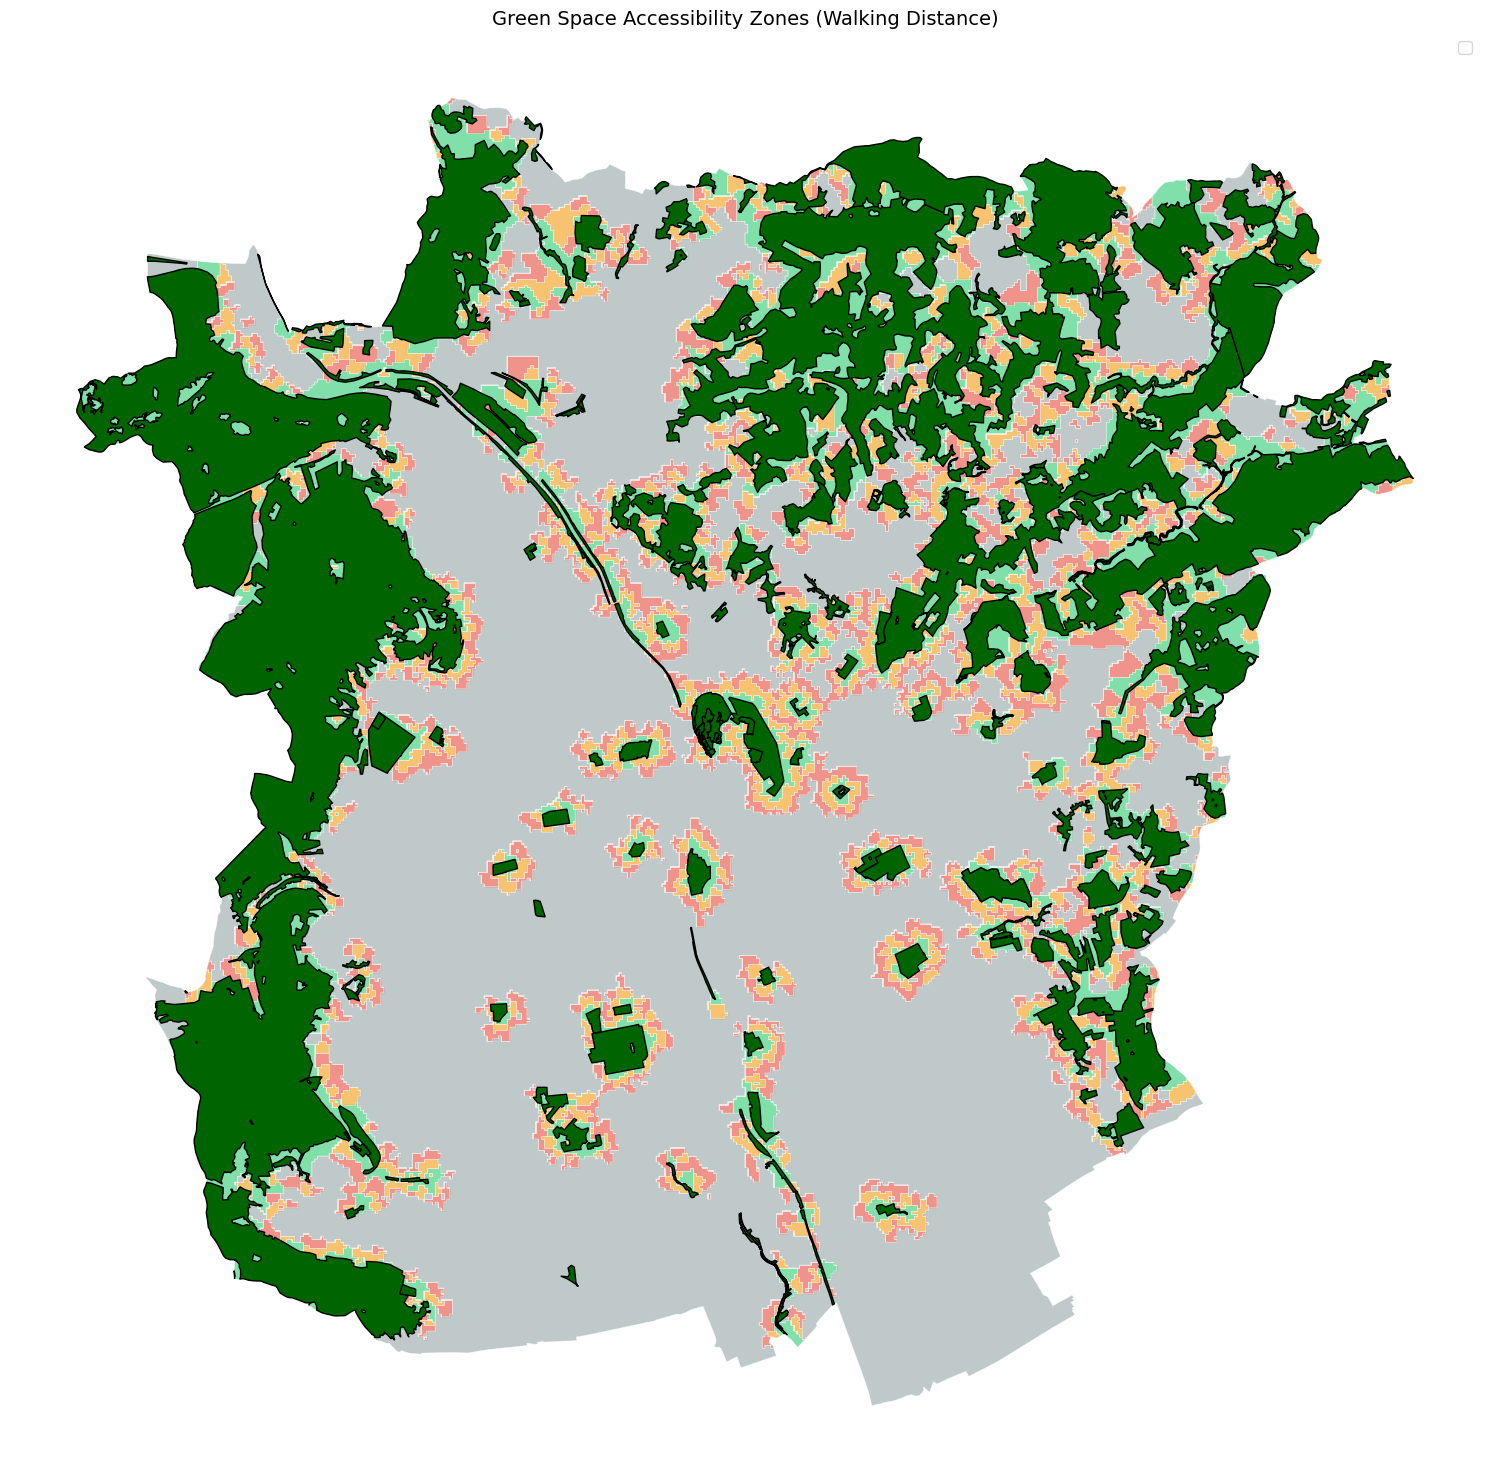

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot zones
for idx, row in zones_gdf.iterrows():
    gpd.GeoSeries([row.geometry]).plot(
        ax=ax,
        color=row['color'],
        alpha=0.6,
        edgecolor='white',
        linewidth=0.5,
        label=row['category']
    )

# Plot green spaces on top
public_green_over_1ha.plot(ax=ax, color='darkgreen', alpha=1, edgecolor='black', label='Green Spaces')

ax.legend(loc='upper right', fontsize=12)
ax.set_title('Green Space Accessibility Zones (Walking Distance)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()